<ipython-input-18-19350669fb1f>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/50
33/32 [==============================] - ETA: 0s - loss: 0.4537 - accuracy: 0.8059

32/32 [==============================] - 240s 2s/step - loss: 0.4537 - accuracy: 0.8059 - val_loss: 0.4379 - val_accuracy: 0.7795 - lr: 9.9966e-05
Epoch 2/50
33/32 [==============================] - ETA: 0s - loss: 0.2327 - accuracy: 0.9106

32/32 [==============================] - 47s 1s/step - loss: 0.2327 - accuracy: 0.9106 - val_loss: 1.2699 - val_accuracy: 0.7529 - lr: 9.9932e-05
Epoch 3/50
33/32 [==============================] - ETA: 0s - loss: 0.2055 - accuracy: 0.9049

32/32 [==============================] - 48s 1s/step - loss: 0.2055 - accuracy: 0.9049 - val_loss: 0.3785 - val_accuracy: 0.8973 - lr: 9.9897e-05
Epoch 4/50
33/32 [==============================] - ETA: 0s - loss: 0.1595 - accuracy: 0.9420

32/32 [==============================] - 46s 1s/step - loss: 0.1595 - accuracy: 0.9420 - val_loss: 0.1645 - val_accuracy: 0.9278 - lr: 9.9862e-05
Epoch 5/50
33/32 [==============================] - ETA: 0s - loss: 0.1565 - accuracy: 0.9410

32/32 [==============================] - 46s 1s/step - loss: 0.1565 - accuracy: 0.9410 - val_loss: 0.2518 - val_accuracy: 0.9430 - lr: 9.9827e-05
Epoch 6/50
33/32 [==============================] - ETA: 0s - loss: 0.1636 - accuracy: 0.9353

32/32 [==============================] - 47s 1s/step - loss: 0.1636 - accuracy: 0.9353 - val_loss: 0.1642 - val_accuracy: 0.9316 - lr: 9.9793e-05
Epoch 7/50
33/32 [==============================] - ETA: 0s - loss: 0.1232 - accuracy: 0.9562

32/32 [==============================] - 48s 1s/step - loss: 0.1232 - accuracy: 0.9562 - val_loss: 0.0313 - val_accuracy: 0.9924 - lr: 9.9758e-05
Epoch 8/50
33/32 [==============================] - ETA: 0s - loss: 0.1195 - accuracy: 0.9543

32/32 [==============================] - 48s 1s/step - loss: 0.1195 - accuracy: 0.9543 - val_loss: 0.0242 - val_accuracy: 0.9924 - lr: 9.9723e-05
Epoch 9/50
33/32 [==============================] - ETA: 0s - loss: 0.1325 - accuracy: 0.9600

32/32 [==============================] - 47s 1s/step - loss: 0.1325 - accuracy: 0.9600 - val_loss: 0.0296 - val_accuracy: 0.9886 - lr: 9.9689e-05
Epoch 10/50
33/32 [==============================] - ETA: 0s - loss: 0.1568 - accuracy: 0.9343

32/32 [==============================] - 48s 1s/step - loss: 0.1568 - accuracy: 0.9343 - val_loss: 0.7641 - val_accuracy: 0.8213 - lr: 9.9654e-05
Epoch 11/50
33/32 [==============================] - ETA: 0s - loss: 0.1442 - accuracy: 0.9458

32/32 [==============================] - 47s 1s/step - loss: 0.1442 - accuracy: 0.9458 - val_loss: 0.0496 - val_accuracy: 0.9810 - lr: 9.9619e-05
Epoch 12/50
33/32 [==============================] - ETA: 0s - loss: 0.1437 - accuracy: 0.9410

32/32 [==============================] - 46s 1s/step - loss: 0.1437 - accuracy: 0.9410 - val_loss: 0.0415 - val_accuracy: 0.9810 - lr: 9.9585e-05
Epoch 13/50
33/32 [==============================] - ETA: 0s - loss: 0.1118 - accuracy: 0.9534

32/32 [==============================] - 45s 1s/step - loss: 0.1118 - accuracy: 0.9534 - val_loss: 0.3354 - val_accuracy: 0.8935 - lr: 9.9550e-05
Epoch 14/50
33/32 [==============================] - ETA: 0s - loss: 0.1468 - accuracy: 0.9353

32/32 [==============================] - 48s 1s/step - loss: 0.1468 - accuracy: 0.9353 - val_loss: 0.0603 - val_accuracy: 0.9848 - lr: 9.9515e-05
Epoch 15/50
33/32 [==============================] - ETA: 0s - loss: 0.1106 - accuracy: 0.9581

32/32 [==============================] - 46s 1s/step - loss: 0.1106 - accuracy: 0.9581 - val_loss: 0.1232 - val_accuracy: 0.9658 - lr: 9.9481e-05
Epoch 16/50
33/32 [==============================] - ETA: 0s - loss: 0.1444 - accuracy: 0.9448

32/32 [==============================] - 46s 1s/step - loss: 0.1444 - accuracy: 0.9448 - val_loss: 0.0518 - val_accuracy: 0.9848 - lr: 9.9446e-05
Epoch 17/50
33/32 [==============================] - ETA: 0s - loss: 0.1064 - accuracy: 0.9562

32/32 [==============================] - 47s 1s/step - loss: 0.1064 - accuracy: 0.9562 - val_loss: 0.0305 - val_accuracy: 0.9924 - lr: 9.9412e-05
Epoch 18/50
33/32 [==============================] - ETA: 0s - loss: 0.0999 - accuracy: 0.9610

32/32 [==============================] - 48s 1s/step - loss: 0.0999 - accuracy: 0.9610 - val_loss: 0.0465 - val_accuracy: 0.9810 - lr: 9.9377e-05
Epoch 19/50
33/32 [==============================] - ETA: 0s - loss: 0.1221 - accuracy: 0.9477

32/32 [==============================] - 46s 1s/step - loss: 0.1221 - accuracy: 0.9477 - val_loss: 0.0679 - val_accuracy: 0.9772 - lr: 9.9343e-05
Epoch 20/50
33/32 [==============================] - ETA: 0s - loss: 0.1281 - accuracy: 0.9505

32/32 [==============================] - 51s 2s/step - loss: 0.1281 - accuracy: 0.9505 - val_loss: 0.0399 - val_accuracy: 0.9810 - lr: 9.9308e-05
Epoch 21/50
33/32 [==============================] - ETA: 0s - loss: 0.1171 - accuracy: 0.9572

32/32 [==============================] - 46s 1s/step - loss: 0.1171 - accuracy: 0.9572 - val_loss: 0.0486 - val_accuracy: 0.9772 - lr: 9.9274e-05
Epoch 22/50
33/32 [==============================] - ETA: 0s - loss: 0.0972 - accuracy: 0.9591

32/32 [==============================] - 48s 1s/step - loss: 0.0972 - accuracy: 0.9591 - val_loss: 0.0646 - val_accuracy: 0.9772 - lr: 9.9239e-05
Epoch 23/50
33/32 [==============================] - ETA: 0s - loss: 0.1022 - accuracy: 0.9638

32/32 [==============================] - 46s 1s/step - loss: 0.1022 - accuracy: 0.9638 - val_loss: 0.0136 - val_accuracy: 0.9962 - lr: 9.9205e-05
Epoch 24/50
33/32 [==============================] - ETA: 0s - loss: 0.1011 - accuracy: 0.9572

32/32 [==============================] - 48s 1s/step - loss: 0.1011 - accuracy: 0.9572 - val_loss: 0.0721 - val_accuracy: 0.9848 - lr: 9.9170e-05
Epoch 25/50
33/32 [==============================] - ETA: 0s - loss: 0.1144 - accuracy: 0.9562

32/32 [==============================] - 46s 1s/step - loss: 0.1144 - accuracy: 0.9562 - val_loss: 0.0261 - val_accuracy: 0.9848 - lr: 9.9136e-05
Epoch 26/50
33/32 [==============================] - ETA: 0s - loss: 0.1005 - accuracy: 0.9619

32/32 [==============================] - 48s 1s/step - loss: 0.1005 - accuracy: 0.9619 - val_loss: 0.0204 - val_accuracy: 0.9924 - lr: 9.9101e-05
Epoch 27/50
33/32 [==============================] - ETA: 0s - loss: 0.1081 - accuracy: 0.9581

32/32 [==============================] - 48s 1s/step - loss: 0.1081 - accuracy: 0.9581 - val_loss: 0.0269 - val_accuracy: 0.9962 - lr: 9.9067e-05
Epoch 28/50
33/32 [==============================] - ETA: 0s - loss: 0.1066 - accuracy: 0.9562

32/32 [==============================] - 47s 1s/step - loss: 0.1066 - accuracy: 0.9562 - val_loss: 0.0338 - val_accuracy: 0.9962 - lr: 9.9032e-05
Epoch 29/50
33/32 [==============================] - ETA: 0s - loss: 0.0936 - accuracy: 0.9610

32/32 [==============================] - 48s 1s/step - loss: 0.0936 - accuracy: 0.9610 - val_loss: 0.0260 - val_accuracy: 0.9848 - lr: 9.8998e-05
Epoch 30/50
33/32 [==============================] - ETA: 0s - loss: 0.1158 - accuracy: 0.9591

32/32 [==============================] - 46s 1s/step - loss: 0.1158 - accuracy: 0.9591 - val_loss: 0.0280 - val_accuracy: 0.9810 - lr: 9.8963e-05
Epoch 31/50
33/32 [==============================] - ETA: 0s - loss: 0.0877 - accuracy: 0.9619

32/32 [==============================] - 48s 1s/step - loss: 0.0877 - accuracy: 0.9619 - val_loss: 0.0290 - val_accuracy: 0.9924 - lr: 9.8929e-05
Epoch 32/50
33/32 [==============================] - ETA: 0s - loss: 0.1076 - accuracy: 0.9553

32/32 [==============================] - 46s 1s/step - loss: 0.1076 - accuracy: 0.9553 - val_loss: 0.0534 - val_accuracy: 0.9886 - lr: 9.8895e-05
Epoch 33/50
33/32 [==============================] - ETA: 0s - loss: 0.1084 - accuracy: 0.9515

32/32 [==============================] - 46s 1s/step - loss: 0.1084 - accuracy: 0.9515 - val_loss: 0.2659 - val_accuracy: 0.9696 - lr: 9.8860e-05
Epoch 34/50
33/32 [==============================] - ETA: 0s - loss: 0.0925 - accuracy: 0.9629

32/32 [==============================] - 48s 1s/step - loss: 0.0925 - accuracy: 0.9629 - val_loss: 0.0436 - val_accuracy: 0.9924 - lr: 9.8826e-05
Epoch 35/50
33/32 [==============================] - ETA: 0s - loss: 0.1035 - accuracy: 0.9534

32/32 [==============================] - 48s 1s/step - loss: 0.1035 - accuracy: 0.9534 - val_loss: 0.0507 - val_accuracy: 0.9924 - lr: 9.8792e-05
Epoch 36/50
33/32 [==============================] - ETA: 0s - loss: 0.0737 - accuracy: 0.9781

32/32 [==============================] - 46s 1s/step - loss: 0.0737 - accuracy: 0.9781 - val_loss: 0.0578 - val_accuracy: 0.9924 - lr: 9.8757e-05
Epoch 37/50
33/32 [==============================] - ETA: 0s - loss: 0.1340 - accuracy: 0.9477

32/32 [==============================] - 45s 1s/step - loss: 0.1340 - accuracy: 0.9477 - val_loss: 0.0359 - val_accuracy: 0.9886 - lr: 9.8723e-05
Epoch 38/50
33/32 [==============================] - ETA: 0s - loss: 0.0910 - accuracy: 0.9600

32/32 [==============================] - 46s 1s/step - loss: 0.0910 - accuracy: 0.9600 - val_loss: 0.0800 - val_accuracy: 0.9696 - lr: 9.8689e-05
Epoch 39/50
33/32 [==============================] - ETA: 0s - loss: 0.0955 - accuracy: 0.9638

32/32 [==============================] - 46s 1s/step - loss: 0.0955 - accuracy: 0.9638 - val_loss: 0.0307 - val_accuracy: 0.9962 - lr: 9.8654e-05
Epoch 40/50
33/32 [==============================] - ETA: 0s - loss: 0.0757 - accuracy: 0.9676

32/32 [==============================] - 46s 1s/step - loss: 0.0757 - accuracy: 0.9676 - val_loss: 0.0384 - val_accuracy: 0.9810 - lr: 9.8620e-05
Epoch 41/50
33/32 [==============================] - ETA: 0s - loss: 0.0772 - accuracy: 0.9667

32/32 [==============================] - 47s 1s/step - loss: 0.0772 - accuracy: 0.9667 - val_loss: 0.0151 - val_accuracy: 0.9962 - lr: 9.8586e-05
Epoch 42/50
33/32 [==============================] - ETA: 0s - loss: 0.0971 - accuracy: 0.9581

32/32 [==============================] - 45s 1s/step - loss: 0.0971 - accuracy: 0.9581 - val_loss: 0.0665 - val_accuracy: 0.9696 - lr: 9.8551e-05
Epoch 43/50
33/32 [==============================] - ETA: 0s - loss: 0.0974 - accuracy: 0.9638

32/32 [==============================] - 48s 1s/step - loss: 0.0974 - accuracy: 0.9638 - val_loss: 0.0557 - val_accuracy: 0.9848 - lr: 9.8517e-05
Epoch 44/50
33/32 [==============================] - ETA: 0s - loss: 0.0951 - accuracy: 0.9591

32/32 [==============================] - 48s 1s/step - loss: 0.0951 - accuracy: 0.9591 - val_loss: 0.0381 - val_accuracy: 0.9848 - lr: 9.8483e-05
Epoch 45/50
33/32 [==============================] - ETA: 0s - loss: 0.0891 - accuracy: 0.9705

32/32 [==============================] - 45s 1s/step - loss: 0.0891 - accuracy: 0.9705 - val_loss: 0.0188 - val_accuracy: 0.9962 - lr: 9.8449e-05
Epoch 46/50
33/32 [==============================] - ETA: 0s - loss: 0.0812 - accuracy: 0.9715

32/32 [==============================] - 46s 1s/step - loss: 0.0812 - accuracy: 0.9715 - val_loss: 0.0700 - val_accuracy: 0.9772 - lr: 9.8414e-05
Epoch 47/50
33/32 [==============================] - ETA: 0s - loss: 0.0838 - accuracy: 0.9696

32/32 [==============================] - 46s 1s/step - loss: 0.0838 - accuracy: 0.9696 - val_loss: 1.2289 - val_accuracy: 0.6502 - lr: 9.8380e-05
Epoch 48/50
33/32 [==============================] - ETA: 0s - loss: 0.0831 - accuracy: 0.9705

32/32 [==============================] - 48s 1s/step - loss: 0.0831 - accuracy: 0.9705 - val_loss: 0.0679 - val_accuracy: 0.9924 - lr: 9.8346e-05
Epoch 49/50
33/32 [==============================] - ETA: 0s - loss: 0.0979 - accuracy: 0.9591

32/32 [==============================] - 49s 1s/step - loss: 0.0979 - accuracy: 0.9591 - val_loss: 0.0488 - val_accuracy: 0.9886 - lr: 9.8312e-05
Epoch 50/50
33/32 [==============================] - ETA: 0s - loss: 0.1056 - accuracy: 0.9524

18/18 [==============================] - 15s 680ms/step
Confusion matrix, without normalization
[[325   5]
 [  0 233]]


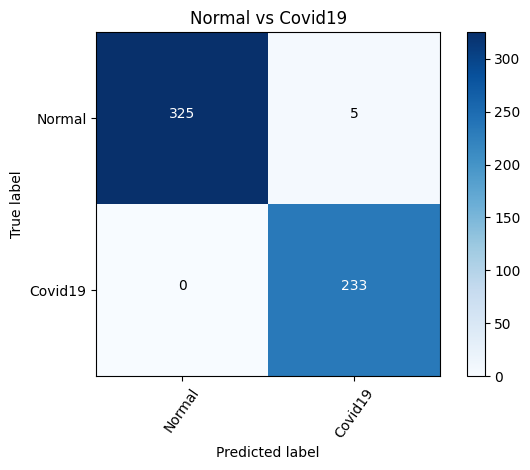

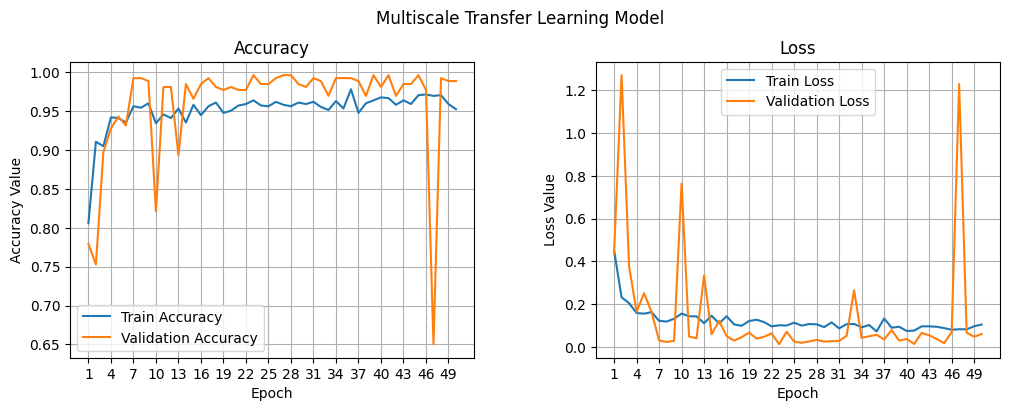

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
from torchvision.utils import make_grid
import os
from PIL import Image
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import matplotlib.pyplot as plt

# Mount Google Drive (if needed)
# from google.colab import drive
# drive.mount('/gdrive')

# Define custom Dataset class
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Define data directories
data_dir = '/content/drive/MyDrive/Covid-19'
train_normal_dir = os.path.join(data_dir, 'train', 'normal')
train_covid19_dir = os.path.join(data_dir, 'train', 'covid-19')
test_normal_dir = os.path.join(data_dir, 'test', 'normal')
test_covid19_dir = os.path.join(data_dir, 'test', 'covid-19')

# Define image size and batch size
IMAGE_SIZE = 224
BATCH_SIZE = 32

# Data augmentation and transformation
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(90),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
])

# Load and split data
def load_data(data_dir, transform):
    image_paths = []
    labels = []

    for class_dir, label in [(train_normal_dir, 0), (train_covid19_dir, 1)]:
        for filename in os.listdir(class_dir):
            if filename.endswith(".png"):
                image_paths.append(os.path.join(class_dir, filename))
                labels.append(label)

    return CustomDataset(image_paths, labels, transform)

dataset = load_data(data_dir, train_transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# Define the model
class MultiNet(nn.Module):
    def __init__(self, num_classes):
        super(MultiNet, self).__init__()
        self.dennet = models.densenet169(pretrained=True)
        self.resnet = models.resnet50(pretrained=True)
        self.vgg = models.vgg19(pretrained=True)
        self.fc1 = nn.Linear(3 * 1664, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.2)
        self.batchnorm = nn.BatchNorm1d(3 * 1664)

    def forward(self, x):
        x1 = self.dennet(x)
        x2 = self.resnet(x)
        x3 = self.vgg(x)
        x1 = x1.view(x1.size(0), -1)
        x2 = x2.view(x2.size(0), -1)
        x3 = x3.view(x3.size(0), -1)
        x = torch.cat((x1, x2, x3), dim=1)
        x = self.batchnorm(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Create the model
num_classes = 2
model = MultiNet(num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion.to(device)

# Learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

# Training loop
num_epochs = 5
best_val_accuracy = 0.0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}")

    # Validation
    model.eval()
    val_corrects = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels.data)

        val_accuracy = val_corrects.double() / len(val_loader.dataset)
        print(f"Validation Accuracy: {val_accuracy:.4f}")

        # Check if the current model has the best validation accuracy
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), "/content/drive/MyDrive/best_binary_multinet.pth")
            print("Saved best model")

    # Adjust learning rate
    lr_scheduler.step()

# Load the best model
model.load_state_dict(torch.load("/content/drive/MyDrive/best_binary_multinet.pth"))
model.eval()

# Test the model (similar to validation but on the test set)
test_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
])

test_dataset = load_data(test_normal_dir, test_transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

test_corrects = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        test_corrects += torch.sum(preds == labels.data)

test_accuracy = test_corrects.double() / len(test_loader.dataset)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Additional evaluation metrics can be calculated here


from sklearn.metrics import confusion_matrix
Y_pred = model.predict(X_test)
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label =['Normal', 'Covid19']
plot_confusion_matrix(cm, cm_plot_label, title ='Normal vs Covid19')

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Multiscale Transfer Learning Model', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,51))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.grid()
ax1.set_xticks(np.arange(1, 51, 3))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.grid()
ax2.set_xticks(np.arange(1, 51, 3))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")